In [6]:
%matplotlib inline
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from torch.autograd import Variable
print(torch.__version__)

1.0.0


In [46]:
class IMUDataset(Dataset):
    def __init__(self, mode = 'test', transform = None):
        if mode == 'train' :
            self.df = pd.read_csv('final_data/train.csv', header = None)
        elif mode == 'test' :
            self.df = pd.read_csv('final_data/test.csv', header = None)
        elif mode == 'val' :
            self.df = pd.read_csv('final_data/val.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        y = self.df.iloc[idx : idx + 300, 6 : ].values
        ind = np.argmax(np.sum(y, axis = 0))
        label = np.zeros_like(self.df.iloc[0, 6 : ].values)
        label = label.astype('float')
        label[ind] = 1
        x = self.df.iloc[idx : idx + 300, : 6].values
        x = x.astype('float')
        assert(x.shape == (300, 6))
        assert(label.shape == (4, ))
        return x, label
        
trainset = IMUDataset(mode = 'train')
valset = IMUDataset(mode = 'val')
testset = IMUDataset(mode = 'test')

(52500, 10)
(6600, 10)
(6600, 10)


In [48]:
reqd_len = 300
train_batch_size = 8
batch_size = 2
train_indices = [(i * reqd_len) for i in range(len(trainset) // reqd_len)]
val_indices = [(i * reqd_len) for i in range(len(valset) // reqd_len)]
test_indices = [(i * reqd_len) for i in range(len(testset) // reqd_len)]

trainloader = DataLoader(trainset, batch_size = train_batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)
valloader = DataLoader(valset, batch_size = batch_size, sampler = SubsetRandomSampler(val_indices), drop_last = True)
testloader = DataLoader(testset, batch_size = batch_size, sampler = SubsetRandomSampler(test_indices), drop_last = True)

signal, label = next(iter(trainloader))
print(signal.shape)
print(label.shape)

torch.Size([8, 300, 6])
torch.Size([8, 4])


In [51]:
# print(len(trainloader))
# print(len(testloader))
# print(len(valloader))
def output_size(n, f, p = 0, s = 1):
    return (((n + 2 * p - f) / s) + 1)
print(output_size(300, 3))
print(output_size(298, 3))
print(output_size(296, 3))

298.0
296.0
294.0


In [59]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # defining layers
        self.conv1 = nn.Conv1d(6, 10, 3)
        self.conv2 = nn.Conv1d(10, 15, 3)
        self.conv3 = nn.Conv1d(15, 20, 3)
        self.fc1 = nn.Linear(294 * 20, 512)
        self.fc2 = nn.Linear(512, 4)
        
        nn.init.xavier_uniform_(self.conv1.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.conv2.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.conv3.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc1.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc2.weight, gain = nn.init.calculate_gain('sigmoid'))
        
    def forward(self, signal):
        signal = signal.view(-1, 6, 300)
        out = F.relu(self.conv1(signal))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = out.view(-1, 294 * 20)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        out = F.log_softmax(out, dim = 1)
        return out

Net = ConvNet()
if torch.cuda.is_available():
    print('Model on GPU')
    Net = Net.cuda()

In [60]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr=1e-3)

In [61]:
num_epochs = 30
total_step = len(trainset) // train_batch_size
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().float()
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).float()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)

        y_pred = Net(images)
        
        loss = criterion(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().float()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).float()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net(images)
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), '3conv2fc.pt')

epoch =  0  step =  0  of total steps  6562  loss =  1.3489880561828613
epoch =  0  step =  20  of total steps  6562  loss =  1.0555881261825562
epoch :  0  /  30  | TL :  2.14180094287509  | VL :  1.0195603370666504
saving model
epoch =  1  step =  0  of total steps  6562  loss =  1.0251587629318237
epoch =  1  step =  20  of total steps  6562  loss =  0.46779364347457886
epoch :  1  /  30  | TL :  0.6004469352109092  | VL :  0.2959310710430145
saving model
epoch =  2  step =  0  of total steps  6562  loss =  0.19593290984630585
epoch =  2  step =  20  of total steps  6562  loss =  0.06102434918284416
epoch :  2  /  30  | TL :  0.16898431753118834  | VL :  0.07256618142127991
saving model
epoch =  3  step =  0  of total steps  6562  loss =  0.062477145344018936
epoch =  3  step =  20  of total steps  6562  loss =  0.02252955175936222
epoch :  3  /  30  | TL :  0.0806790887422505  | VL :  0.032675620168447495
saving model
epoch =  4  step =  0  of total steps  6562  loss =  0.027937553

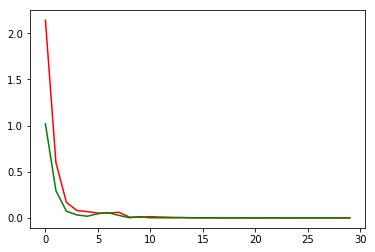

In [62]:
j = np.arange(30)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')